<a href="https://colab.research.google.com/github/fabiansep/TesisSMA/blob/main/SMA_Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import pandas as pd
import ee
from google.colab import userdata
from google.colab import drive
from datetime import datetime, timedelta
import time
import os
import threading
from google.colab import auth
from google.cloud import storage

# Explicación

Este notebook busca la informacion satelital y guarda en un bucket de GCP. Se tiene que pasar el nombre de una región (que tiene que coincidir con los nombres de regiones del shape del congreso). Saca todas las comunas de dicha región, crea n-hilos para buscar de forma asincrona dado un rango de años de forma decendiente. La información se captura de forma semanal, partiendo el 01-01 de cada año. y se almacena en formato .csv de forma anual.

# Indicaciones

Se debe contar con un proyecto en Google Earth Engine: https://code.earthengine.google.com/

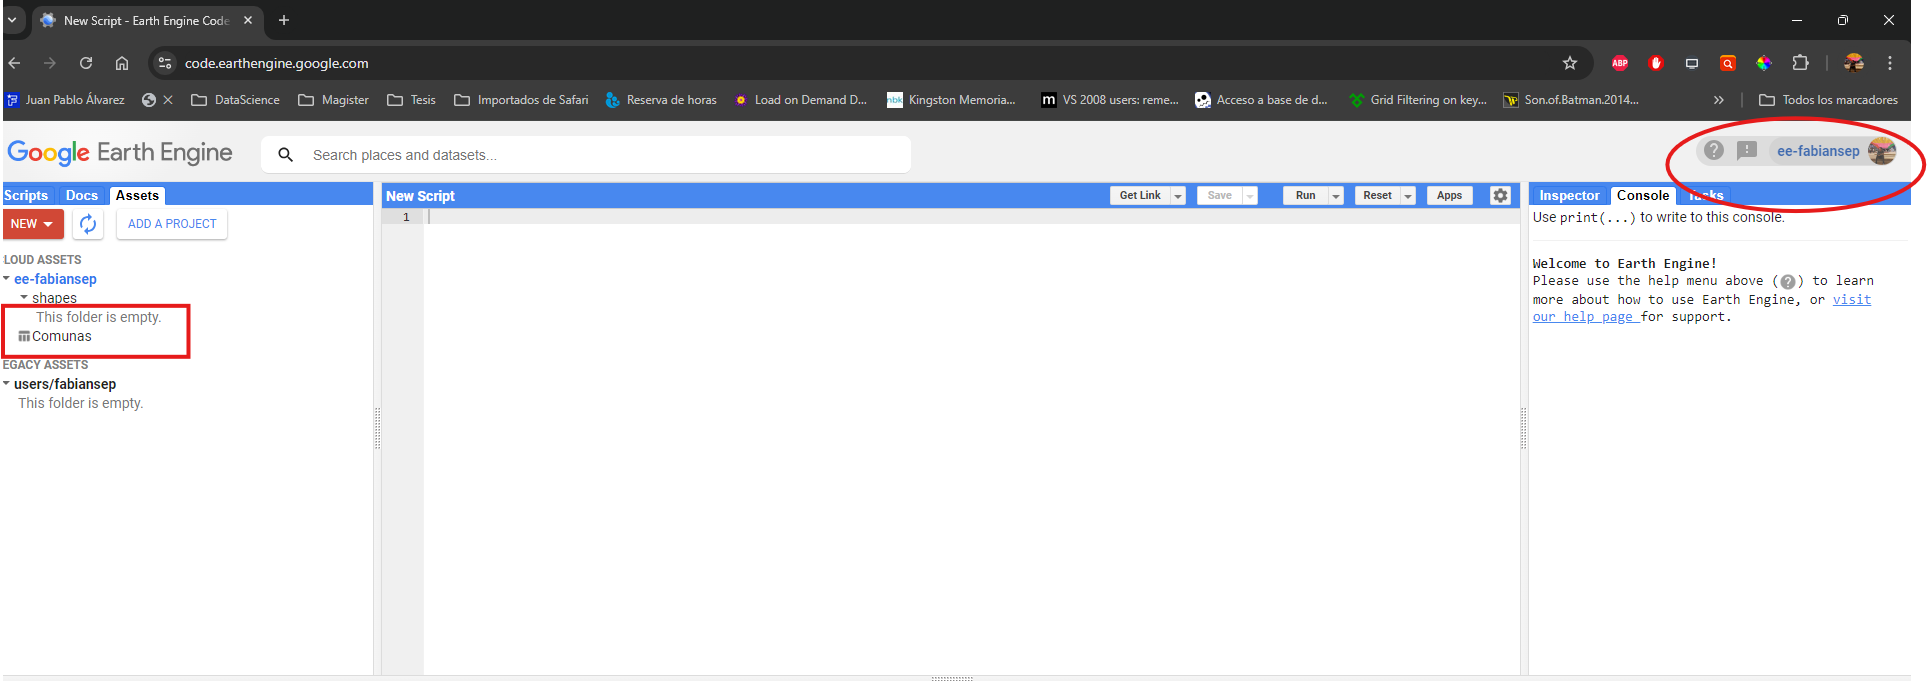

Se debe tener cargado el shapefile de la división comunal [https://www.bcn.cl/siit/mapas_vectoriales](https://www.bcn.cl/siit/mapas_vectoriales)

Una vez que se haya cargado el archivo, hacer click sobre el para ver detalles. Copiar el Table ID


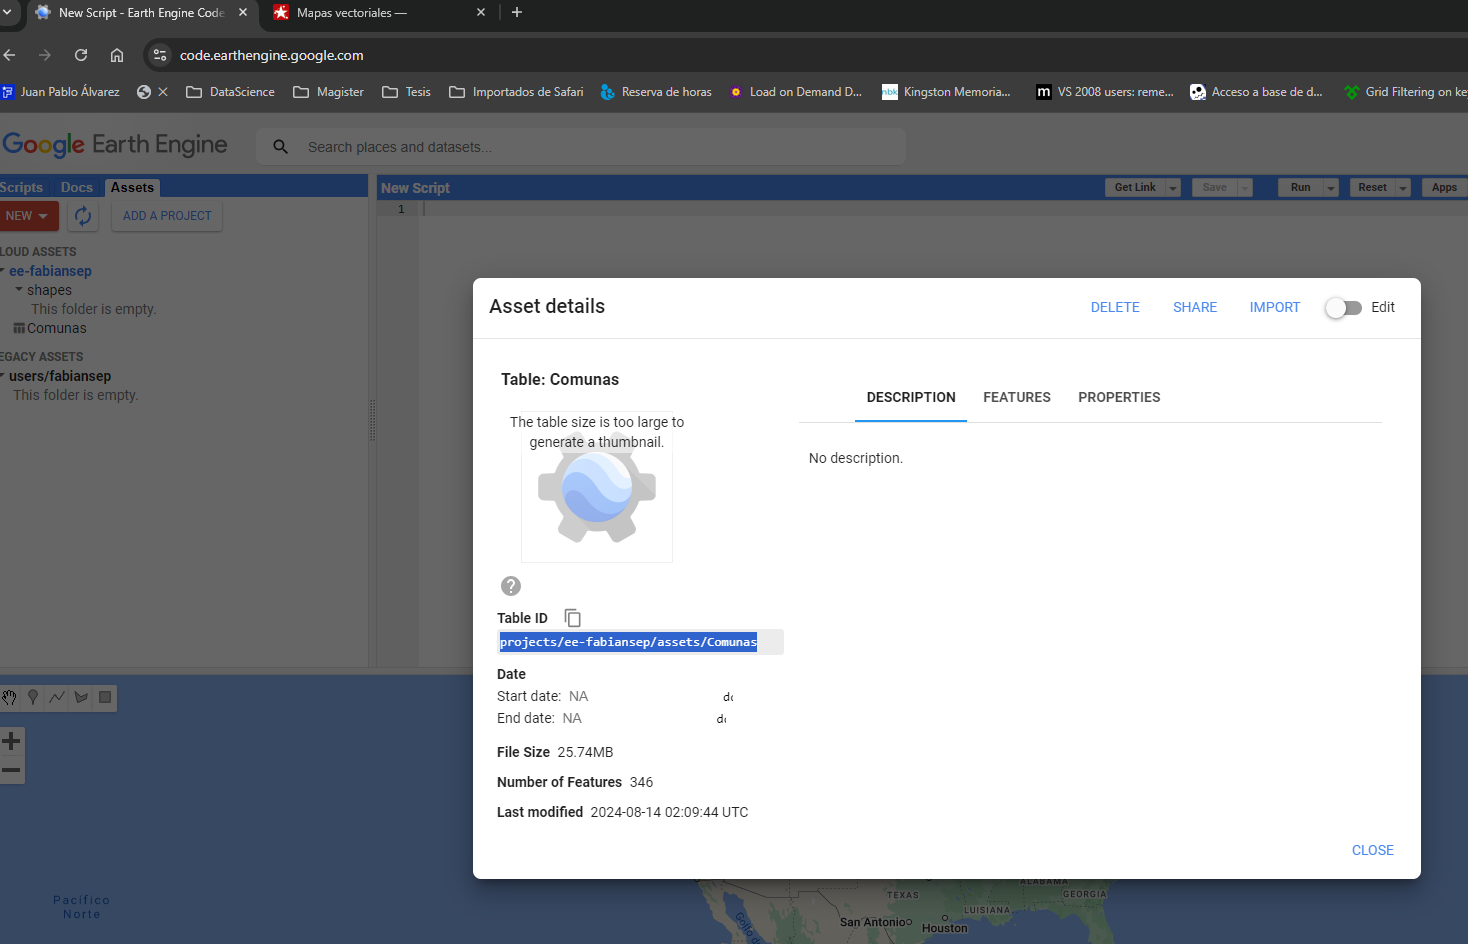

In [ ]:
auth.authenticate_user()

In [ ]:
ee.Authenticate()
#Acá va el proyect ID (costado superior derecho)
ee.Initialize(project='ee-fabiansep')

In [ ]:
#Acá va el Table ID de Comunas
comunas = ee.FeatureCollection('projects/ee-fabiansep/assets/Comunas')

In [ ]:
region_name = 'Región de Aysén del Gral.Ibañez del Campo'

In [ ]:
# Función para calcular el promedio semanal
def calcular_promedio_semanal(comuna, start_date, end_date):
    collection = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
        .filterDate(start_date, end_date) \
        .filterBounds(comuna.geometry()) \
        .select('Optical_Depth_047')

    # Verificar si hay imágenes en la colección después del filtrado
    if collection.size().getInfo() == 0:
        return None  # No hay imágenes disponibles

    weekly_mean = collection.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=comuna.geometry(),
        scale=500,
        maxPixels=1e9
    )

    # Manejar posibles resultados nulos
    optical_depth_value = weekly_mean.get('Optical_Depth_047').getInfo()
    if optical_depth_value is None:
        return np.nan  # O el valor que prefieras para indicar datos faltantes
    return optical_depth_value

In [ ]:
def procesar_comuna_por_anio(nombre_comuna, anio_desde, anio_hasta):

    client = storage.Client()
    bucket_name = 'tesis_data' #este es el bucket, deberias tener acceso a él
    bucket = client.get_bucket(bucket_name)
    comuna = comunas.filter(ee.Filter.eq('Comuna', nombre_comuna)).first()

    if not comuna:
        print(f"La comuna '{nombre_comuna}' no se encontró.")
        return

    for year in range(anio_hasta, anio_desde - 1, -1):
        end_of_year = datetime(year, 12, 31)
        current_date = datetime(year, 1, 1)

        # Definir el nombre del archivo CSV que se guardará en el bucket
        comuna_csv_filename = f'resultados_{nombre_comuna}_{year}.csv'
        comuna_csv_path = f'comunas/{comuna_csv_filename}'  # Ruta dentro del bucket

        start_time_year = time.time()

        # Verificar si el archivo ya existe en el bucket
        blob = bucket.blob(comuna_csv_path)
        try:
            if blob.exists():
                print(f"Datos {nombre_comuna}-{year} ya existen en el bucket. Saltando.")
                continue
        except google.api_core.exceptions.Forbidden:
            print(f"")

        resultados = []
        while current_date <= end_of_year:
            start_time_week = time.time()
            next_week = current_date + timedelta(days=7)
            end_weekDay = next_week + timedelta(days=-1)

            promedio = calcular_promedio_semanal(comuna, current_date.strftime('%Y-%m-%d'), end_weekDay.strftime('%Y-%m-%d'))

            # Añadir al DataFrame
            resultados.append({
                'Comuna': nombre_comuna,
                'Region': comuna.get('Region').getInfo(),  # Obtener la región de la comuna
                'fecha_desde': current_date.strftime('%Y-%m-%d'),
                'fecha_hasta': end_weekDay.strftime('%Y-%m-%d'),
                'valor_medio_optical_depth_047': promedio
            })

            end_time_week = time.time()
            duration_week = end_time_week - start_time_week

            # Imprimir detalles de la búsqueda actual
            print(f"Comuna: {nombre_comuna}, Fecha Desde: {current_date.strftime('%Y-%m-%d')}, Fecha Hasta: {end_weekDay.strftime('%Y-%m-%d')} Duracion: {duration_week:.2f}")

            current_date = next_week

        end_time_year = time.time()
        duration_year = end_time_year - start_time_year
        print(f"Comuna: {nombre_comuna} Duracion Procesar Anio: {duration_year:.2f}")

        df_intermedio = pd.DataFrame(resultados)
        # Guardar el DataFrame como un archivo CSV temporalmente
        temp_csv_path = f'/tmp/{comuna_csv_filename}'
        df_intermedio.to_csv(temp_csv_path, index=False)

        # Subir el archivo CSV al bucket
        blob.upload_from_filename(temp_csv_path)

        # Eliminar el archivo temporal
        os.remove(temp_csv_path)

In [ ]:
def obtener_comunas_por_region(nombre_region):
    # Filtrar la colección de comunas por la región especificada
    comunas_region = comunas.filter(ee.Filter.eq('Region', nombre_region))

    # Extraer los nombres de las comunas
    comunas_list = comunas_region.aggregate_array('Comuna').getInfo()

    return comunas_list

In [ ]:
comunas_region = obtener_comunas_por_region(region_name)
anio_desde = 2019
anio_hasta = 2024

tareas = list(map(lambda comuna: {"nombre_comuna": comuna, "anio_desde": anio_desde, "anio_hasta": anio_hasta}, comunas_region))

In [ ]:
tareas

[{'nombre_comuna': 'Río Ibáñez', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Chile Chico', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Lago Verde', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Coyhaique', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Cisnes', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Tortel', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': "O'Higgins", 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Cochrane', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Guaitecas', 'anio_desde': 2019, 'anio_hasta': 2024},
 {'nombre_comuna': 'Aysén', 'anio_desde': 2019, 'anio_hasta': 2024}]

In [ ]:
# Lista para almacenar los hilos
threads = []
# Tamaño del bloque
block_size = 5

# Crear y lanzar hilos en bloques de 5
for i, tarea_info in enumerate(tareas):
    t = threading.Thread(target=procesar_comuna_por_anio, args=(tarea_info["nombre_comuna"], tarea_info["anio_desde"], tarea_info["anio_hasta"]))
    threads.append(t)
    t.start()

    # Si hemos lanzado 5 hilos o hemos alcanzado el final de la lista de tareas
    if (i + 1) % block_size == 0 or (i + 1) == len(tareas):
        # Esperar a que los hilos actuales terminen
        for t in threads:
            t.join()
        # Vaciar la lista de hilos para el siguiente bloque
        threads = []

Datos Cochrane-2024 ya existen en el bucket. Saltando.
Datos Río Ibáñez-2024 ya existen en el bucket. Saltando.
Datos Coyhaique-2024 ya existen en el bucket. Saltando.
Datos Lago Verde-2024 ya existen en el bucket. Saltando.
Datos Tortel-2024 ya existen en el bucket. Saltando.
Datos O'Higgins-2024 ya existen en el bucket. Saltando.Datos Cochrane-2023 ya existen en el bucket. Saltando.

Datos Guaitecas-2024 ya existen en el bucket. Saltando.
Datos Chile Chico-2024 ya existen en el bucket. Saltando.
Datos Coyhaique-2023 ya existen en el bucket. Saltando.
Datos Río Ibáñez-2023 ya existen en el bucket. Saltando.
Datos Cochrane-2022 ya existen en el bucket. Saltando.
Datos O'Higgins-2023 ya existen en el bucket. Saltando.
Datos Guaitecas-2023 ya existen en el bucket. Saltando.
Comuna: O'Higgins, Fecha Desde: 2022-01-01, Fecha Hasta: 2022-01-07 Duracion: 2.54
Datos Lago Verde-2023 ya existen en el bucket. Saltando.
Datos Coyhaique-2022 ya existen en el bucket. Saltando.
Datos Lago Verde-2022

Exception in thread Thread-16 (procesar_comuna_por_anio):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-5089e266cfab>", line 67, in procesar_comuna_por_anio
FileNotFoundError: [Errno 2] No such file or directory: "/tmp/resultados_O'Higgins_2020.csv"


Comuna: Cisnes, Fecha Desde: 2024-03-18, Fecha Hasta: 2024-03-24 Duracion: 62.17
Comuna: Guaitecas, Fecha Desde: 2021-05-07, Fecha Hasta: 2021-05-13 Duracion: 9.62
Comuna: O'Higgins, Fecha Desde: 2019-01-01, Fecha Hasta: 2019-01-07 Duracion: 5.35
Comuna: Tortel, Fecha Desde: 2023-08-13, Fecha Hasta: 2023-08-19 Duracion: 27.02
Comuna: Guaitecas, Fecha Desde: 2021-05-14, Fecha Hasta: 2021-05-20 Duracion: 9.08
Comuna: O'Higgins, Fecha Desde: 2019-01-08, Fecha Hasta: 2019-01-14 Duracion: 6.28
Comuna: Guaitecas, Fecha Desde: 2021-05-21, Fecha Hasta: 2021-05-27 Duracion: 9.05
Comuna: O'Higgins, Fecha Desde: 2019-01-15, Fecha Hasta: 2019-01-21 Duracion: 11.69
Comuna: Tortel, Fecha Desde: 2023-08-20, Fecha Hasta: 2023-08-26 Duracion: 23.33
Comuna: Guaitecas, Fecha Desde: 2021-05-28, Fecha Hasta: 2021-06-03 Duracion: 10.24
Comuna: O'Higgins, Fecha Desde: 2019-01-22, Fecha Hasta: 2019-01-28 Duracion: 7.36
Comuna: O'Higgins, Fecha Desde: 2019-01-29, Fecha Hasta: 2019-02-04 Duracion: 6.11
Comuna: 

Exception in thread Thread-24 (procesar_comuna_por_anio):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-15-e72bdd8dc944>", line 70, in procesar_comuna_por_anio
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/resultados_Cisnes_2023.csv'


Comuna: Tortel, Fecha Desde: 2020-07-22, Fecha Hasta: 2020-07-28 Duracion: 28.67
Comuna: Tortel, Fecha Desde: 2020-07-29, Fecha Hasta: 2020-08-04 Duracion: 25.02
Comuna: Aysén, Fecha Desde: 2023-06-18, Fecha Hasta: 2023-06-24 Duracion: 78.87
Comuna: Aysén, Fecha Desde: 2023-06-18, Fecha Hasta: 2023-06-24 Duracion: 79.37
Comuna: Tortel, Fecha Desde: 2020-08-05, Fecha Hasta: 2020-08-11 Duracion: 27.13
Comuna: Tortel, Fecha Desde: 2020-08-12, Fecha Hasta: 2020-08-18 Duracion: 22.46
Comuna: Cisnes, Fecha Desde: 2022-01-01, Fecha Hasta: 2022-01-07 Duracion: 87.53
Comuna: Tortel, Fecha Desde: 2020-08-19, Fecha Hasta: 2020-08-25 Duracion: 24.85
Comuna: Tortel, Fecha Desde: 2020-08-26, Fecha Hasta: 2020-09-01 Duracion: 26.61
Comuna: Aysén, Fecha Desde: 2023-06-25, Fecha Hasta: 2023-07-01 Duracion: 86.08
Comuna: Aysén, Fecha Desde: 2023-06-25, Fecha Hasta: 2023-07-01 Duracion: 89.02
Comuna: Cisnes, Fecha Desde: 2022-01-08, Fecha Hasta: 2022-01-14 Duracion: 68.37
Comuna: Tortel, Fecha Desde: 202

Comuna: Aysén, Fecha Desde: 2023-12-31, Fecha Hasta: 2024-01-06 Duracion: 102.92
Comuna: Aysén Duracion Procesar Anio: 5506.32


Exception in thread Thread-19 (procesar_comuna_por_anio):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-5089e266cfab>", line 67, in procesar_comuna_por_anio
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/resultados_Aysén_2023.csv'


Comuna: Cisnes, Fecha Desde: 2022-11-19, Fecha Hasta: 2022-11-25 Duracion: 81.13
Comuna: Aysén, Fecha Desde: 2022-01-01, Fecha Hasta: 2022-01-07 Duracion: 104.05
Comuna: Cisnes, Fecha Desde: 2022-11-26, Fecha Hasta: 2022-12-02 Duracion: 93.52
Comuna: Aysén, Fecha Desde: 2022-01-08, Fecha Hasta: 2022-01-14 Duracion: 138.18
Comuna: Cisnes, Fecha Desde: 2022-12-03, Fecha Hasta: 2022-12-09 Duracion: 84.47
Comuna: Cisnes, Fecha Desde: 2022-12-10, Fecha Hasta: 2022-12-16 Duracion: 76.64
Comuna: Aysén, Fecha Desde: 2022-01-15, Fecha Hasta: 2022-01-21 Duracion: 96.94
Comuna: Cisnes, Fecha Desde: 2022-12-17, Fecha Hasta: 2022-12-23 Duracion: 64.17
Comuna: Aysén, Fecha Desde: 2022-01-22, Fecha Hasta: 2022-01-28 Duracion: 107.38
Comuna: Cisnes, Fecha Desde: 2022-12-24, Fecha Hasta: 2022-12-30 Duracion: 67.24
Comuna: Cisnes, Fecha Desde: 2022-12-31, Fecha Hasta: 2023-01-06 Duracion: 74.11
Comuna: Cisnes Duracion Procesar Anio: 3466.51
Comuna: Aysén, Fecha Desde: 2022-01-29, Fecha Hasta: 2022-02-04